<font size=6  color= 'blue' > <b>[LEPL1507] - PROJET P4</b> <br>
<br><br>
Airson Alexis<br>
Beniffou Ibrahim <br>
Henneaux Lucas <br>
Lemaire Antoine <br>
Smith Marielle <br>
Canon Théo<br>
<div style="text-align: right"> </div>

<br><br>
</font>


In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import os
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
#preprocessing of ppm dataset 
path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'
nbr_class = 62

DIR = path_training
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_train = counter

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = (30, 30),
batch_size = batch_size_train,class_mode = 'binary', color_mode='rgb')

DIR = path_testing
counter = 0
for root, dirs, files in os.walk(DIR):
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print(counter)

batch_size_test = counter

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(path_testing,
target_size = (30, 30),batch_size = batch_size_test, class_mode = 'binary')


4575
Found 4575 images belonging to 62 classes.
2520
Found 2520 images belonging to 62 classes.


training_set = ensemble de 143 tuples
Chaque tuple représente 32 images (sauf le dernier, 31 images)

tuple[0] = features = tableau (32, 30, 30, 3)
tuple[1] = label = tableau (32)

plt.imshow(training_set[i][0][j]) affiche l'image n°j du paquet d'image n°i 

In [3]:
'''
On met toutes les données du Training Set dans un numpy array
'''

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#data augmentation
'''aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
aug.fit(X_train)'''

(4575, 30, 30, 3)
(4575,)
(2520, 30, 30, 3)
(2520,)


'aug = ImageDataGenerator(\n\trotation_range=10,\n\tzoom_range=0.15,\n\twidth_shift_range=0.1,\n\theight_shift_range=0.1,\n\tshear_range=0.15,\n\thorizontal_flip=False,\n\tvertical_flip=False,\n\tfill_mode="nearest")\naug.fit(X_train)'

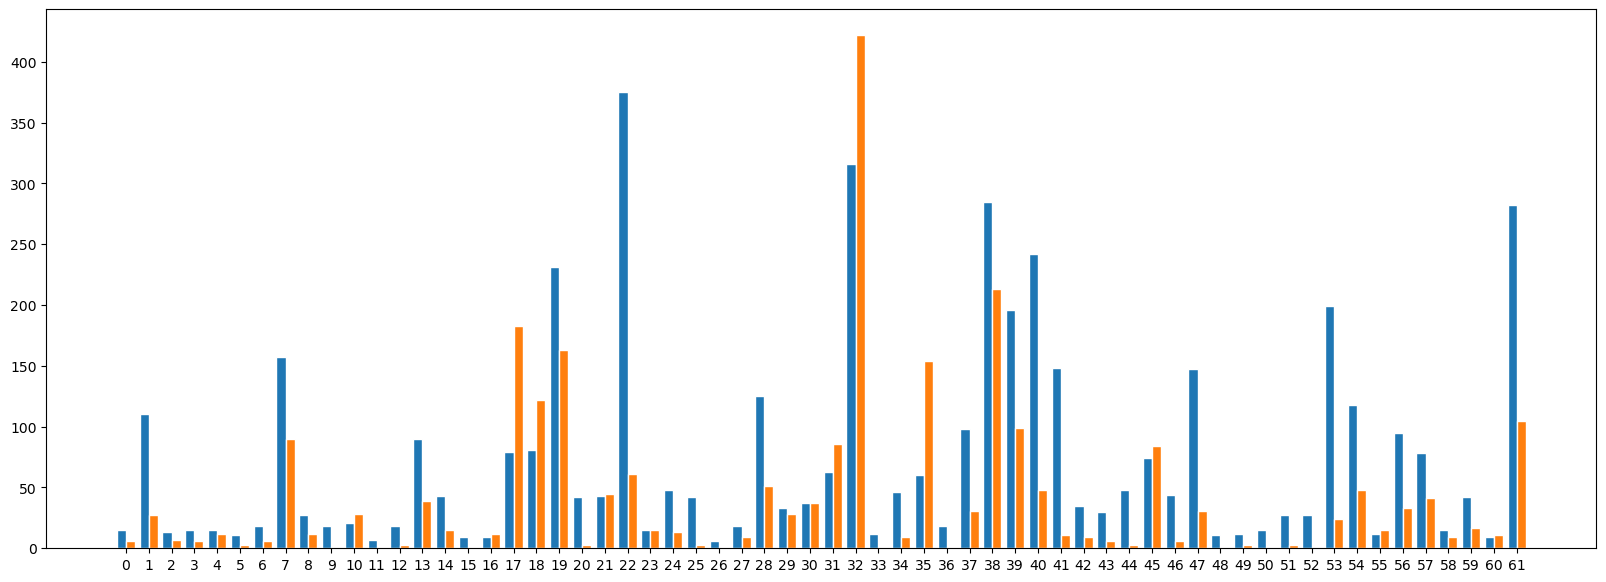

In [4]:
a = np.zeros(62, dtype=int)
b = np.zeros(62, dtype=int)
for i in range(62) :
    a[i] = int((y_train == i).sum())
    b[i] = int((y_test == i).sum())

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, 62)]
ax.hist([y_train, y_test], range = (0, 61), bins=bins, edgecolor = 'white')
plt.xticks(np.arange(62))
plt.show()

In [5]:

'''
Augmentation de données :

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(64, 64, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image = data_augmentation(X_train[a:b])
augmented_image = data_augmentation(X_test[c:d])
==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris

idx = random.randint(a, b)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])

plt.subplot(1, 2, 2)
plt.imshow(augmented_image[idx])

'''

'\nAugmentation de données :\n\ndata_augmentation = tf.keras.Sequential(\n    [\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            "horizontal", input_shape=(64, 64, 3)),\n        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),\n        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            mode="horizontal_and_vertical")\n    ]\n)\n\naugmented_image = data_augmentation(X_train[a:b])\naugmented_image = data_augmentation(X_test[c:d])\n==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris\n\nidx = random.randint(a, b)\nplt.figure()\nplt.subplot(1, 2, 1)\nplt.imshow(X_train[idx])\n\nplt.subplot(1, 2, 2)\nplt.imshow(augmented_image[idx])\n\n'

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(30, 30, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image_train = data_augmentation(X_train)
augmented_image_test = data_augmentation(X_test)

ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(4575, 30, 30, 3)

In [14]:
memory = np.zeros((62, 2), dtype=int)
counter_train = 0
counter_test = 0
for i in range(62) :
    if a[i] < 3*b[i]/4 :  # On ajoute dans le Training Set
        if len(np.where(y_train == i)[0]) != 0 :
            memory[i][0] = np.abs(3*b[i]/4 - a[i])
            counter_train += int(np.abs(3*b[i]/4 - a[i]))
    elif b[i] < 3*a[i]/4 :  # On ajoute dans le Test Set
        if len(np.where(y_test == i)[0]) != 0 :
            memory[i][1] = np.abs(int(3*b[i]/4 - a[i]))
            counter_test += int(np.abs(int(3*b[i]/4 - a[i])))

X_train_new = np.zeros((len(X_train) + counter_train, 64, 64, 3))
y_train_new = np.zeros(len(y_train) + counter_train)
X_train_new[:len(X_train)] = X_train
y_train_new[:len(y_train)] = y_train

X_test_new = np.zeros((len(X_test) + counter_test, 64, 64, 3))
y_test_new = np.zeros(len(y_test) + counter_test)
X_test_new[:len(X_test)] = X_test
y_test_new[:len(y_test)] = y_test

index_train = len(X_train)
index_test = len(X_test)
for i in range(62) :
    if memory[i][0] > 0 : # On dans le Training Set
        indices = np.where(y_train == i)
        augmented_image = data_augmentation(X_train[indices])
        for j in range(memory[i][0]) :
            idx = random.randint(0, len(indices[0])-1)
            X_train_new[index_train] = augmented_image[idx]
            y_train_new[index_train] = i
            index_train += 1
    
    elif memory[i][1] > 0 : # On ajoute du Training Set dans le Test Set
        indices = np.where(y_test == i)
        augmented_image = data_augmentation(X_test[indices])
        for j in range(memory[i][1]) :
            idx = random.randint(0, len(indices[0])-1)
            X_test_new[index_test] = augmented_image[idx]
            y_test_new[index_test] = i
            index_test += 1

ValueError: could not broadcast input array from shape (4575,30,30,3) into shape (4575,64,64,3)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, 62)]
ax.hist([y_train_new, y_test_new], range = (0, 61), bins=bins, edgecolor = 'white')
plt.xticks(np.arange(62))
plt.show()

In [ ]:
y_train = to_categorical(y_train, nbr_class)
y_test = to_categorical(y_test, nbr_class)

print(y_train.shape)
print(y_test.shape)

In [ ]:
'''
On construit le modèle de prédiction sur base de la méthode CNN
'''

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

79/79 [==============================] - 2s 30ms/step
2520
[[[[0.3137255  0.21960786 0.18039216]
   [0.30588236 0.18039216 0.18039216]
   [0.3529412  0.5764706  0.6039216 ]
   ...
   [0.6392157  0.43921572 0.3647059 ]
   [0.6509804  0.47450984 0.38823533]
   [0.627451   0.4666667  0.36862746]]

  [[0.34509805 0.24705884 0.20392159]
   [0.3647059  0.23529413 0.24313727]
   [0.48235297 0.70980394 0.7568628 ]
   ...
   [0.627451   0.5176471  0.43529415]
   [0.61960787 0.50980395 0.41960788]
   [0.62352943 0.49803925 0.40784317]]

  [[0.34117648 0.23529413 0.18039216]
   [0.3254902  0.19215688 0.20784315]
   [0.5058824  0.76470596 0.8196079 ]
   ...
   [0.5411765  0.3803922  0.32941177]
   [0.54901963 0.4431373  0.3647059 ]
   [0.5529412  0.427451   0.3647059 ]]

  ...

  [[0.35686275 0.42352945 0.5019608 ]
   [0.85098046 1.         1.        ]
   [0.9607844  0.7725491  0.59607846]
   ...
   [0.16078432 0.14117648 0.14117648]
   [0.18431373 0.14509805 0.14117648]
   [0.19215688 0.14509805 

In [ ]:
'''
On entraîne le modèle de prédiction
'''

eps = 15
#mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(aug.flow(X_train, y_train), validation_data=(X_test, y_test), epochs=eps)
#added aug.flow to (X_train, y_train) to do data augmentation


In [ ]:
'''
On plot les résultats de performances
'''

plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# evaluate the network
label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

print("[INFO] evaluating network...")
predictions = model.predict(X_test) 
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names, labels=range(61)))


A partir d'un ensemble de feature X_predict :

pred = model.predict_classes(X_predict)
print(accuracy_score(y_predict, pred))